In [44]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb
import sklearn.model_selection as model_selection
import contextily as cx
import geopandas as gpd

gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

# Utils

In [4]:
def rmlse(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

# Load data metro

In [45]:
# Read the building datasets
buildings_train = pd.read_csv("resources/data/buildings_train.csv").set_index("id")
buildings_train["split"] = "train"
buildings_test = pd.read_csv("resources/data/buildings_test.csv").set_index("id")
buildings_test["split"] = "test"

# Create a GeoDataFrame of all buildings
buildings = pd.concat([buildings_train, buildings_test])
buildings = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(
    buildings.longitude, buildings.latitude, crs="EPSG:4326"
))

stations = gpd.read_file("resources/metro_stations.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# The Earth's radius in meters
EARTH_RADIUS = 6371000

# Create temporary columns for coordinates given in radians
stations["lon_rad"] = np.radians(stations.geometry.x)
stations["lat_rad"] = np.radians(stations.geometry.y)
buildings["lon_rad"] = np.radians(buildings.longitude)
buildings["lat_rad"] = np.radians(buildings.latitude)

# Calculate the distance to the nearest metro station for each building using
# the haversine formula with the Earth's radius as given above
buildings["metro_distance"] = buildings.apply(
    lambda row: np.min(
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((stations.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(stations.lat_rad)
                * np.sin((stations.lon_rad - row.lon_rad) / 2) ** 2
            )
        )
    ),
    axis=1,
)

# Drop the temporary radian columns
stations.drop(columns=["lon_rad", "lat_rad"], inplace=True)
buildings.drop(columns=["lon_rad", "lat_rad"], inplace=True)

In [51]:
buildings_train = buildings.loc[buildings["split"] == "train", :].drop(columns = "split", inplace = True)
buildings_train.drop(columns = "split", inplace = True)
buildings_train

AttributeError: 'NoneType' object has no attribute 'head'

# Load Data

In [5]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

# LightGBM
I try some hyperparameter tuning with optuna, but I am not able to use the rmlse, which is strange. Need to experiment more with this.

In [34]:
import optuna 
from sklearn.model_selection import KFold
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    params = {
        'verbose': -1,
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': 3000,
        #'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        #'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        #'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
        #'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
        lgb_eval = lgb.Dataset(X_test, y_test,free_raw_data=False)
        model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=False, early_stopping_rounds=100)
        
        """
        model = lgb.LGBMRegressor(objective="regression", silent = True, **param)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=100
        )
        """
        preds = model.predict(X_test)
        cv_scores[idx] = rmlse(y_test, preds)

    return np.mean(cv_scores)

    optuna.logging.set_verbosity(optuna.logging.INFO)

In [37]:
import warnings
warnings.filterwarnings("ignore")

features = ['latitude', 'longitude', 'constructed', 'area_total', 'rooms']
X = data[features]   
y = np.log(data['price'])

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=10)

[I 2021-10-12 14:58:17,044] A new study created in memory with name: LGBM Regressor
[I 2021-10-12 14:59:13,530] Trial 0 finished with value: 0.009410860426865272 and parameters: {'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 386, 'min_child_samples': 234}. Best is trial 0 with value: 0.009410860426865272.
[I 2021-10-12 15:00:05,012] Trial 1 finished with value: 0.009826179864794515 and parameters: {'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 791, 'min_child_samples': 300}. Best is trial 0 with value: 0.009410860426865272.
[I 2021-10-12 15:01:13,972] Trial 2 finished with value: 0.008922914786195179 and parameters: {'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 426, 'min_child_samples': 113}. Best is trial 2 with value: 0.008922914786195179.
[I 2021-10-12 15:02:06,449] Trial 3 finished with value: 0.009571986960539399 and parameters: {'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 818, 'min_child_samples': 298}. Best is trial 2 with value: 0.008922914

In [38]:
print(f"\tBest value (rmlse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmlse): 0.00883
	Best params:
		learning_rate: 0.02
		max_depth: 100
		num_leaves: 330
		min_child_samples: 114


In [39]:
features = ['latitude', 'longitude', 'constructed', 'area_total', 'rooms']

X_train = data[features]
y_train = data.loc[X_train.index].price

lgb_mod = lgb.LGBMRegressor(
    random_state = 48,
    metric='rmse',
    n_estimators=20000,
    **study.best_params
)

lgb_mod.fit(X_train, np.log(y_train))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.02, max_depth=100,
              metric='rmse', min_child_samples=114, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=330,
              objective=None, random_state=48, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

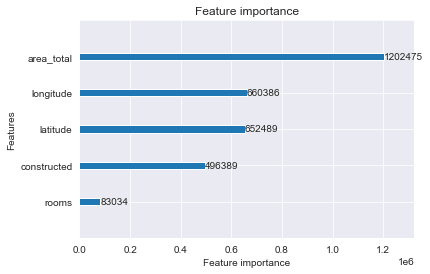

In [42]:
lgb.plot_importance(lgb_mod)


In [40]:
preds_test = lgb_mod.predict(data_test[features])
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = np.exp(preds_test)
submission.to_csv('submissions/lgbm4_submission.csv', index=False)

In [28]:
features = ['latitude', 'longitude', 'constructed', 'area_total', 'rooms']

data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
X_train = data_train[features]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[features]
y_valid = data_valid.loc[X_valid.index].price


lgb_mod = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='rmsle',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05,
    seed = 42
)

lgb_mod.fit(X_train, np.log(y_train))

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.95,
              importance_type='split', learning_rate=0.05, max_depth=5,
              metric='rmsle', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=2000, n_jobs=4, num_leaves=10,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              seed=42, silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [29]:
preds_valid = lgb_mod.predict(X_valid)
print('Validation RMSLE: ', rmlse(y_valid, np.exp(preds_valid)))

Validation RMSLE:  0.16431015822158682


In [37]:
preds_test = lgb_mod.predict(data_test[features])
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = np.exp(preds_test)
submission.to_csv('submissions/lgbm_submission.csv', index=False)


(9937, 33)
(9937,)


array([34783427.25415785,  7639045.30896283,  6145455.69914033, ...,
       10082195.97498193,  8750817.10927868,  6105413.72482848])

# Imputing with KNN.

In [13]:
import sklearn
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 3)


X = data[['longitude', 'latitude', 'constructed']]
nan_idx = X['constructed'].isna()
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
print(X.loc[nan_idx, 'constructed'])
X['constructed'] = X['constructed'].round()
print(X.loc[nan_idx, 'constructed'])


0.22.1
52       2019.000000
70       2019.000000
138      2019.000000
139      2019.000000
171      2021.000000
            ...     
23060    2017.000000
23091    2004.333333
23123    2019.000000
23173    2018.333333
23276    2019.000000
Name: constructed, Length: 794, dtype: float64
52       2019.0
70       2019.0
138      2019.0
139      2019.0
171      2021.0
          ...  
23060    2017.0
23091    2004.0
23123    2019.0
23173    2018.0
23276    2019.0
Name: constructed, Length: 794, dtype: float64


In [14]:
features = ['latitude', 'longitude', 'constructed', 'area_total', 'rooms']

data['constructed'] = X['constructed']
data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
X_train = data_train[features]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[features]
y_valid = data_valid.loc[X_valid.index].price


lgb_mod = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='rmsle',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05,
    seed = 42
)

lgb_mod.fit(X_train, np.log(y_train))

[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.95,
              importance_type='split', learning_rate=0.05, max_depth=5,
              metric='rmsle', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=2000, n_jobs=4, num_leaves=10,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              seed=42, silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [41]:
preds_valid = lgb_mod.predict(X_valid)
print('Validation RMSLE: ', rmlse(y_valid, np.exp(preds_valid)))
lgb.plot_importance(lgb_mod)

NameError: name 'X_valid' is not defined